# Lab 3b: Ensembles
## Using trees to detect trees 

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

In [3]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [4]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

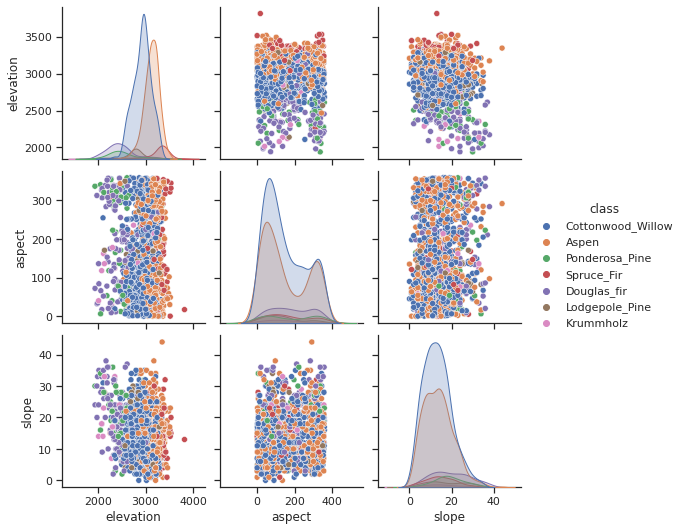

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

In [6]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scoring=None, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i, scoring=scoring) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
            label = f"{scores[k]:.2f}"
            if k == "test":
                plt.annotate(label, (i, scores[k]), textcoords="offset points", xytext=(0,-10), ha='center')
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)



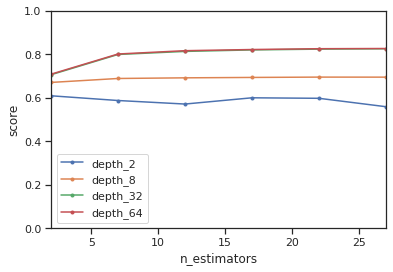

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

def evaluate_RF(X, y, n_estimators, max_depths=[2,8,32,64], scoring=None):
    scores = [np.mean(cross_val_score(RandomForestClassifier(max_depth=depth, random_state=1,
                                                    n_estimators=n_estimators), X, y, scoring=scoring, cv=3, n_jobs=-1)) for depth in max_depths]
    return {f"depth_{depth}": score for depth,score in zip(max_depths, scores)}

def plot_depths_estimators(X, y, scoring=None):
    Xs, _, ys, _ = train_test_split(X, y, train_size=0.5, stratify=y)
    p_range = range(2, 30, 5)
    plot_live(Xs, ys, evaluator=evaluate_RF, scoring=scoring, param_name='n_estimators', param_range=p_range, scale='linear')
    
plot_depths_estimators(X, y)




Random forests with max depth 32 and 64 perform equally good and give the best accuracy scores. \
random forests with max depth 2 seem to perform poorly. \
This is to be expected as we are using a bagging method and we want to reduce variance by
combining multiple high variance, low bias models. \
For the decision trees to have high variance they need to be able to be deep enough.

When using more than 7 estimators the smoothing of the variances seems to have no effect anymore
where we even see oversmoothing for max depth 2 at 27 estimators.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

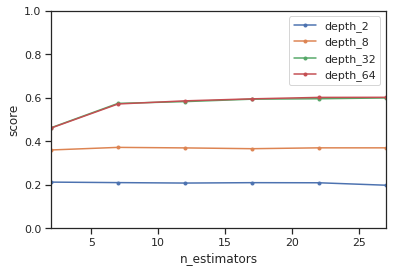

In [8]:
from sklearn.metrics import balanced_accuracy_score
plot_depths_estimators(X, y, 'balanced_accuracy')



the scores are a lot worse now for every number of estimators and max depth used

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

In [9]:
Xs, Xt, ys, yt = train_test_split(X, y, stratify=y)
clf = RandomForestClassifier(random_state=1, max_depth=64, n_estimators=27).fit(Xs, ys)
imp_feats = clf.feature_importances_
feat_names_imports = list(zip(features, imp_feats))
feat_names_imports.sort(key=lambda tup: tup[1], reverse=True)
feat_names_imports


[('elevation', 0.2156643431327398),
 ('Horizontal_Distance_To_Roadways', 0.1053518475576735),
 ('Horizontal_Distance_To_Fire_Points', 0.09879236004316398),
 ('horizontal_distance_to_hydrology', 0.06700931418929),
 ('Vertical_Distance_To_Hydrology', 0.06395007624673517),
 ('aspect', 0.060111753289423975),
 ('Hillshade_Noon', 0.05591681682652512),
 ('Hillshade_3pm', 0.05511994730311862),
 ('Hillshade_9am', 0.053556343017828245),
 ('slope', 0.045631460287447884),
 ('wilderness_area4', 0.029151511784109196),
 ('soil_type_22', 0.013671195866366006),
 ('soil_type_23', 0.010719813729569917),
 ('soil_type_4', 0.010643830643225662),
 ('wilderness_area1', 0.009178484952239416),
 ('wilderness_area3', 0.008715336855558106),
 ('soil_type_38', 0.008346662645092607),
 ('soil_type_39', 0.008326784101709962),
 ('soil_type_12', 0.008237735687396695),
 ('soil_type_10', 0.007951292700249739),
 ('soil_type_2', 0.007839321764197535),
 ('wilderness_area2', 0.005596789477858255),
 ('soil_type_29', 0.005042589

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [10]:
from timeit import default_timer as timer
X_first_10 = X[:,:10]
print(X_first_10.shape)

start = timer()
score = evaluate_RF(X, y, 27, max_depths=[64], scoring='balanced_accuracy')
end = timer()
print(f"balanced_accuracy 10 first features: {score}")
print(f"training time 10 first features: {end-start}")

start = timer()
score = evaluate_RF(X_first_10, y, 27, max_depths=[64], scoring='balanced_accuracy')
end = timer()
print(f"balanced_accuracy 10 first features: {score}")
print(f"training time 10 first features: {end-start}")

(110393, 10)
balanced_accuracy 10 first features: {'depth_64': 0.6539633449023815}
training time 10 first features: 5.066782400001102
balanced_accuracy 10 first features: {'depth_64': 0.6251290881916729}
training time 10 first features: 4.912036300000182


training times are basicaly the same and the score is only slightly worse when using only the 10
first features. This indicates that the first 10 features are the most important and contribute
to almost the full model.

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

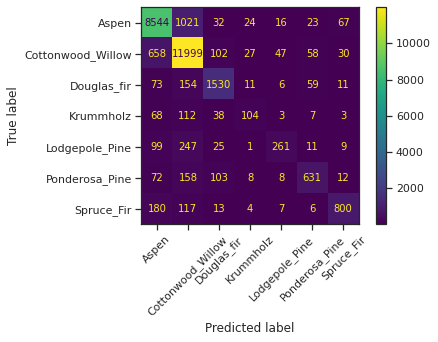

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(random_state=1, max_depth=64, n_estimators=27, n_jobs=-1).fit(Xs, ys)
predictions = clf.predict(Xt)
cm = confusion_matrix(yt, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.xticks(rotation = 45)
plt.show()



Cottonwood willow and Aspen still get confused for each other

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

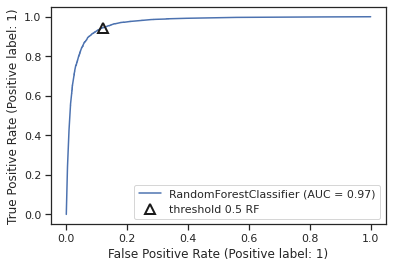

In [12]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
X_filt = X[y < 2, :]
y_filt = y[y < 2]
Xs, Xt, ys, yt = train_test_split(X_filt, y_filt, stratify=y_filt, random_state=1)
clf = RandomForestClassifier(random_state=0, max_depth=32, n_estimators=25, n_jobs=-1).fit(Xs, ys)
RocCurveDisplay.from_estimator(clf, Xt, yt)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(yt, clf.predict_proba(Xt)[:, 1])

# get index of threshold value closest to 0.5 to represent fpr and tpr at threshold 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);




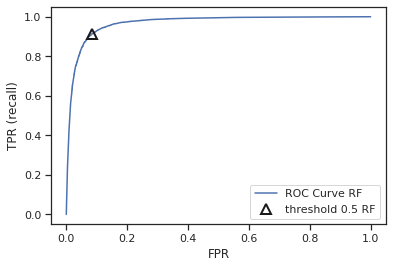

In [13]:
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.6))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)). 
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

In [14]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of pos. samples")
    ax.set(aspect='equal')
    return curve

# Plot calibration curves for `models`, optionally show a calibrator run on a calibratee
def plot_calibration_comparison(models, calibrator=None, calibratee=None): 
    def get_probabilities(clf, X):
        if hasattr(clf, "predict_proba"): # Use probabilities if classifier has predict_proba
            prob_pos = clf.predict_proba(X)[:, 1]
        else:  # Otherwise, use decision function and scale
            prob_pos = clf.decision_function(X)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        return prob_pos
    
    nr_plots = len(models)
    if calibrator:
        nr_plots += 1
    fig, axes = plt.subplots(1, nr_plots, figsize=(3*nr_plots*fig_scale, 4*nr_plots*fig_scale))
    for ax, clf in zip(axes[:len(models)], models):
            clf.fit(Xc_train, yc_train)
            prob_pos = get_probabilities(clf,Xc_test)           
            bs = brier_score_loss(yc_test,prob_pos)
            plot_calibration_curve(yc_test, prob_pos, n_bins=20, ax=ax)
            ax.set_title(clf.__class__.__name__)
            ax.text(0,0.95,"Brier score: {:.3f}".format(bs))
    if calibrator:
        calibratee.fit(Xc_train, yc_train)
        # We're visualizing the trained calibrator, hence let it predict the training data
        prob_pos = get_probabilities(calibratee, Xc_train) # get uncalibrated predictions
        y_sort = [x for _,x in sorted(zip(prob_pos,yc_train))] # sort for nicer plots
        prob_pos.sort()
        cal_prob = calibrator.fit(prob_pos, y_sort).predict(prob_pos) # fit calibrator
        axes[-1].scatter(prob_pos,y_sort, s=2)
        axes[-1].scatter(prob_pos,cal_prob, s=2)
        axes[-1].plot(prob_pos,cal_prob)
        axes[-1].set_title("Calibrator: {}".format(calibrator.__class__.__name__))
        axes[-1].set_xlabel("predicted probability")
        axes[-1].set_ylabel("outcome")
        axes[-1].set(aspect='equal')
    plt.tight_layout()

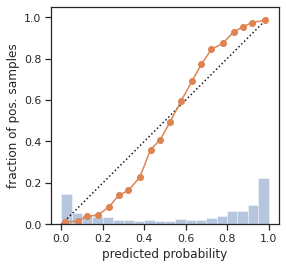

In [33]:
plot_calibration_curve(yt, clf.predict_proba(Xt)[:, 1], n_bins=20)

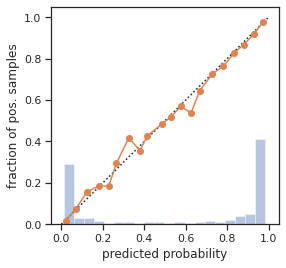

In [34]:
from sklearn.calibration import CalibratedClassifierCV
calib_clf = CalibratedClassifierCV(base_estimator=clf, cv='prefit', n_jobs=-1).fit(Xt, yt)
plot_calibration_curve(yt, calib_clf.predict_proba(Xt)[:,1], n_bins=20)

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

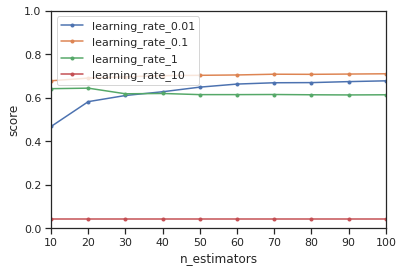

In [31]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_GB(X, y, n_estimators, learning_rates=[0.01, 0.1, 1, 10], scoring=None):
    kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
    # xgb_clf = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=l_rate, random_state=1, use_label_encoder=False)
    
    scores = [np.mean(cross_val_score(GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=l_rate, random_state=1,),X, y, cv=kfold, scoring=scoring, n_jobs=-1)) for l_rate in learning_rates]
    return {f"learning_rate_{l_rate}": score for l_rate,score in zip(learning_rates, scores)}

def plot_GBs(X, y, scoring=None):
    Xs, _, ys, _ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=1)
    n_est = range(10, 101, 10)
    plot_live(Xs, ys, evaluator=evaluate_GB, param_name='n_estimators', param_range=n_est, scale='linear', scoring=scoring)

plot_GBs(X, y , scoring='accuracy')
    

    